# Lab6

In [1]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [2]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

## Q1 - Population Growth Rate 

- Option 1: Do the calculation in SQL


SELECT 
    p.year,
    p.pop AS population,
    ROUND(
        (p.pop - LAG(p.pop) OVER (ORDER BY p.year)) 
        / LAG(p.pop) OVER (ORDER BY p.year) * 100, 
        2
    ) AS growth_rate_percent
FROM population AS p
JOIN name AS n
    ON p.fips = n.fips
WHERE n.name = 'Arizona'
ORDER BY p.year ASC;

- option 2 

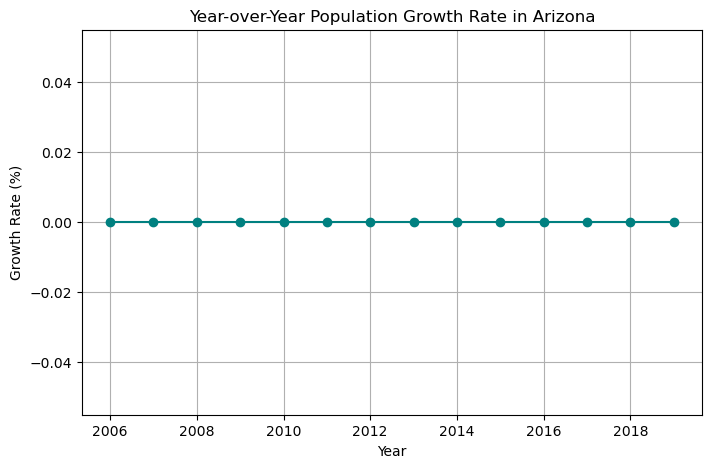

In [5]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt


endpoint = "ia340.c1qu828uqxyx.us-east-1.rds.amazonaws.com"


engine = create_engine(f'postgresql+psycopg2://postgres:ia340data@{endpoint}:5432/postgres')

query = """
SELECT 
    p.year,
    p.pop AS population,
    ROUND(
        (p.pop - LAG(p.pop) OVER (ORDER BY p.year)) 
        / LAG(p.pop) OVER (ORDER BY p.year) * 100, 
        2
    ) AS growth_rate_percent
FROM population AS p
JOIN name AS n
    ON p.fips = n.fips
WHERE n.name = 'Arizona'
ORDER BY p.year ASC;
"""


df = pd.read_sql(query, engine)

# Plot
plt.figure(figsize=(8,5))
plt.plot(df['year'], df['growth_rate_percent'], marker='o', color='teal')
plt.title('Year-over-Year Population Growth Rate in Arizona')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.grid(True)
plt.show()



- this graph shows no population growth for the state of arizona 

## Q2 - Income and population Relationship 

- Option 1: SQL code 

SELECT 
    p.year,
    p.pop AS population,
    i.income AS median_income
FROM population AS p
JOIN income AS i
    ON p.fips = i.fips AND p.year = i.year
JOIN name AS n
    ON p.fips = n.fips
WHERE n.name = 'Arizona'
ORDER BY p.year ASC;


- Option 2: Python code 

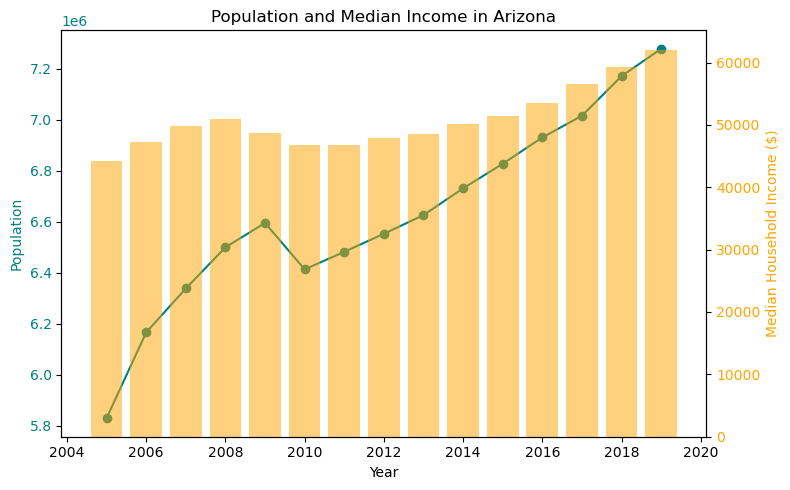

In [7]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt


endpoint = "ia340.c1qu828uqxyx.us-east-1.rds.amazonaws.com" 
engine = create_engine(f'postgresql+psycopg2://postgres:ia340data@{endpoint}:5432/postgres')


query = """
SELECT 
    p.year,
    p.pop AS population,
    i.income AS median_income
FROM population AS p
JOIN income AS i
    ON p.fips = i.fips AND p.year = i.year
JOIN name AS n
    ON p.fips = n.fips
WHERE n.name = 'Arizona'
ORDER BY p.year ASC;
"""


df = pd.read_sql(query, engine)


fig, ax1 = plt.subplots(figsize=(8,5))


ax1.plot(df['year'], df['population'], color='teal', marker='o', label='Population')
ax1.set_xlabel('Year')
ax1.set_ylabel('Population', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')


ax2 = ax1.twinx()
ax2.bar(df['year'], df['median_income'], color='orange', alpha=0.5, label='Median Income')
ax2.set_ylabel('Median Household Income ($)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')


plt.title('Population and Median Income in Arizona')
fig.tight_layout()
plt.show()


- This graph shows a comparison between Arizona's yearly population and median household income. The green line shows a steady population growth and the yellow bars indicate rising income levels. 

## Q3 - Which year had the largest population increase in Arizona

- Option 1: SQL code 

SELECT 
    p.year,
    p.pop AS population,
    (p.pop - LAG(p.pop) OVER (ORDER BY p.year)) AS yearly_increase
FROM population AS p
JOIN name AS n
    ON p.fips = n.fips
WHERE n.name = 'Arizona'
ORDER BY p.year ASC;


- Option 3: Python Code 

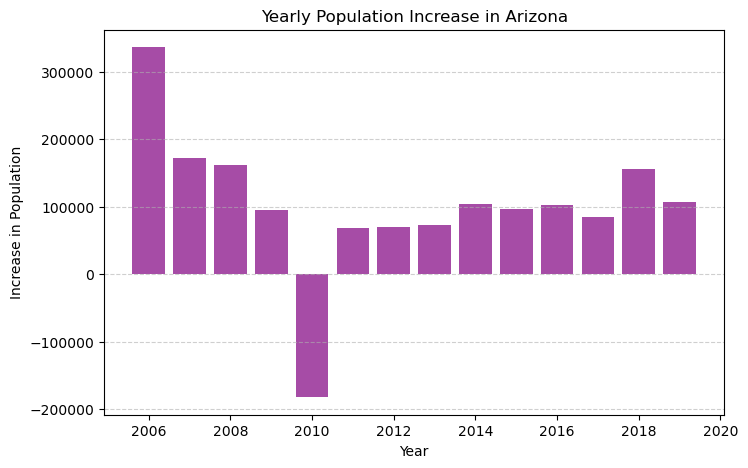

In [8]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt

endpoint = "ia340.c1qu828uqxyx.us-east-1.rds.amazonaws.com" 
engine = create_engine(f'postgresql+psycopg2://postgres:ia340data@{endpoint}:5432/postgres')

query = """
SELECT 
    p.year,
    p.pop AS population,
    (p.pop - LAG(p.pop) OVER (ORDER BY p.year)) AS yearly_increase
FROM population AS p
JOIN name AS n
    ON p.fips = n.fips
WHERE n.name = 'Arizona'
ORDER BY p.year ASC;
"""

df = pd.read_sql(query, engine)


df = df.dropna(subset=['yearly_increase'])


plt.figure(figsize=(8,5))
plt.bar(df['year'], df['yearly_increase'], color='purple', alpha=0.7)
plt.title('Yearly Population Increase in Arizona')
plt.xlabel('Year')
plt.ylabel('Increase in Population')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


- this graph shows arizonas year-over-year population growth. the tallest bar shows the year with the higest level of population growth. 